In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
def parse_labels(path, split):
    img_dir = os.path.join(path, split, "images")
    label_dir = os.path.join(path, split, "labels")

    img_files = sorted(os.listdir(img_dir))
    label_files = [os.path.splitext(f)[0] + ".txt" for f in img_files]

    labels = []
    for lf in label_files:
        label_path = os.path.join(label_dir, lf)
        if not os.path.exists(label_path):
            labels.append(np.zeros((0, 2), dtype=np.float32))  # empty if no label file
            continue

        with open(label_path, "r") as f:
            points_all = []
            for line in f:
                vals = np.fromstring(line.strip(), sep=" ")
                if len(vals) > 5:
                    # guard against odd number of coordinates
                    if (len(vals) - 5) % 2 != 0:
                        continue
                    pts = vals[5:].reshape(-1, 2)
                    points_all.append(pts)

            # choose the single polygon set with the most points
            if points_all:
                best = max(points_all, key=lambda a: a.shape[0])
                points = best.astype(np.float32, copy=False)
            else:
                points = np.zeros((0, 2), dtype=np.float32)

            labels.append(points)

    return img_files, labels

def points_to_heatmap(points, size, sigma=2.0, normalized=True):
    h, w = size
    hm = np.zeros((h, w), dtype=np.float32)
    if points.size == 0:
        return hm
    pts = points.astype(np.float32)
    if normalized:
        pts = pts * np.array([w, h], dtype=np.float32)
    y = np.arange(h, dtype=np.float32)[:, None]
    x = np.arange(w, dtype=np.float32)[None, :]
    for px, py in pts:
        g = np.exp(-((x - px) ** 2 + (y - py) ** 2) / (2.0 * sigma ** 2))
        hm += g
    m = hm.max()
    return hm / m if m > 0 else hm

In [3]:
class SegDataset(Dataset):
    def __init__(self, img_dir, labels, transform=None):
        self.img_dir = img_dir
        self.img_files = sorted(os.listdir(img_dir))
        self.labels = labels  # list/array of same length
        self.transform = transform

    def __len__(self): return len(self.img_files)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, self.img_files[idx])).convert("RGB")
        mask = torch.tensor(self.labels[idx], dtype=torch.float32)  # assume np array of shape (H,W)
        img = img.resize((mask.shape[1], mask.shape[0]), Image.BILINEAR)  # ← one added line
        if self.transform: img = self.transform(img)
        return img, mask

In [4]:
HM_SIZE = (128, 128)  # example

root = "train_madness/Chessboard Detection.v2i.yolov8"

transform = transforms.ToTensor()

img_files, point_lists = parse_labels(root, "train")
heatmaps = [points_to_heatmap(pts, HM_SIZE, sigma=0.5, normalized=True)
            for pts in point_lists]  # shape each: (H, W), float32 in [0, 1]
train_ds = SegDataset(os.path.join(root, "train", "images"), heatmaps, transform=transform)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)

val_img_files, val_points = parse_labels(root, "valid")
val_heatmaps = [points_to_heatmap(pts, HM_SIZE, sigma=0.5, normalized=True)
                for pts in val_points]
val_ds = SegDataset(os.path.join(root, "valid", "images"), val_heatmaps, transform=transform)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# test
test_img_files, test_points = parse_labels(root, "test")
test_heatmaps = [points_to_heatmap(pts, HM_SIZE, sigma=0.5, normalized=True)
                 for pts in test_points]
test_ds = SegDataset(os.path.join(root, "test", "images"), test_heatmaps, transform=transform)
test_dl = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)


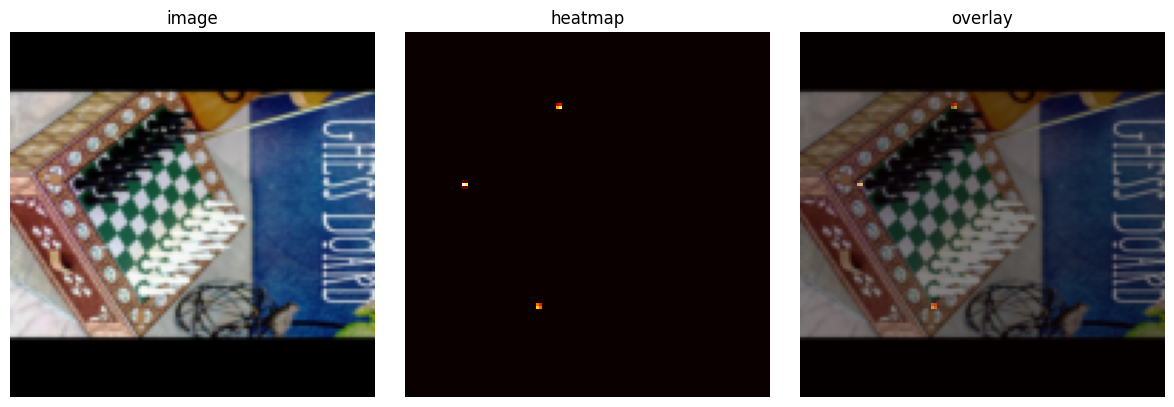

In [5]:
i = 316  # pick any index you want
img, mask = train_ds[i]  # img: Tensor [3, H, W], mask: Tensor [H, W]

# to numpy for imshow
if isinstance(img, torch.Tensor):
    img_vis = img.permute(1, 2, 0).numpy()
else:
    img_vis = np.array(img)
mask_vis = mask.numpy()  # float32 in [0, 1]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img_vis)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("heatmap")
plt.imshow(mask_vis, cmap="hot", interpolation="nearest")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("overlay")
plt.imshow(img_vis)
plt.imshow(mask_vis, cmap="hot", alpha=0.5, interpolation="nearest")
plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
class TinyFCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, 1)  # output 1 heatmap channel
        )
    def forward(self, x): return self.net(x)

In [7]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = TinyFCN().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
print(device)

mps


In [8]:
crit = nn.MSELoss()

@torch.no_grad()
def eval_mse(model, dl, device):
    model.eval()
    total = 0.0
    count = 0
    for imgs, masks in dl:
        imgs = imgs.to(device)
        masks = masks.unsqueeze(1).to(device)   # [B, 1, H, W]
        preds = model(imgs)                     # [B, 1, H, W]
        loss = crit(torch.sigmoid(preds), masks)
        bs = imgs.size(0)
        total += loss.item() * bs
        count += bs
    return total / max(count, 1)

In [9]:
epochs = 20
best_val = float("inf")
for ep in range(epochs):
    model.train()
    running = 0.0
    for imgs, masks in tqdm(train_dl):
        imgs = imgs.to(device)
        masks = masks.unsqueeze(1).to(device)
        preds = model(imgs)
        
        alpha = 9.5  # positives are ~10× more important; tune 4..20
        # logits, not sigmoid
        logits = preds
        # per-pixel BCE
        bce = F.binary_cross_entropy_with_logits(logits, masks, reduction="none")
        # weight positives higher (targets are in [0, 1])
        w = 1.0 + alpha * masks
        loss = (bce * w).mean()

        optim.zero_grad()
        loss.backward()
        optim.step()
        running += loss.item() * imgs.size(0)

    train_loss = running / len(train_ds)
    val_loss = eval_mse(model, val_dl, device)
    print(f"epoch {ep+1}: train {train_loss:.4f}  val {val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_val.ckpt")

  0%|          | 0/132 [00:00<?, ?it/s]/Users/teo/venvs/CV/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 132/132 [00:04<00:00, 32.03it/s]


epoch 1: train 0.0810  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 37.16it/s]


epoch 2: train 0.0134  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 36.14it/s]


epoch 3: train 0.0130  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 36.66it/s]


epoch 4: train 0.0126  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 36.74it/s]


epoch 5: train 0.0124  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 37.09it/s]


epoch 6: train 0.0122  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 37.44it/s]


epoch 7: train 0.0120  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 37.51it/s]


epoch 8: train 0.0119  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 37.35it/s]


epoch 9: train 0.0118  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 37.31it/s]


epoch 10: train 0.0117  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 37.28it/s]


epoch 11: train 0.0116  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 37.13it/s]


epoch 12: train 0.0115  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 37.10it/s]


epoch 13: train 0.0113  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 37.13it/s]


epoch 14: train 0.0113  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 37.40it/s]


epoch 15: train 0.0112  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 36.18it/s]


epoch 16: train 0.0111  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 36.58it/s]


epoch 17: train 0.0111  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 36.87it/s]


epoch 18: train 0.0110  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 36.72it/s]


epoch 19: train 0.0110  val 0.0002


100%|██████████| 132/132 [00:03<00:00, 36.63it/s]


epoch 20: train 0.0108  val 0.0002


In [10]:
model.load_state_dict(torch.load("best_val.ckpt", map_location=device))
test_loss = eval_mse(model, test_dl, device)
print(f"test MSE: {test_loss:.4f}")

test MSE: 0.0002


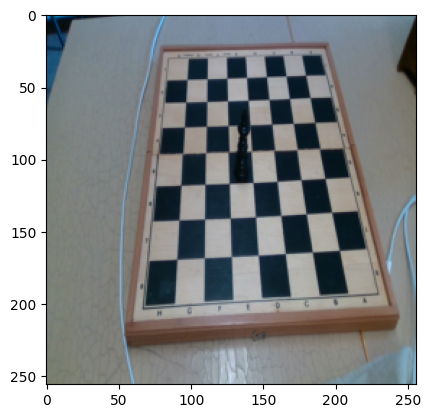

In [11]:
img = Image.open("rs/color.png").convert("RGB")
img = img.resize((256, 256), Image.BILINEAR)
plt.imshow(img)

In [12]:
img = Image.open("rs/color.png").convert("RGB")
img = img.resize(HM_SIZE, Image.BILINEAR)

# transform to tensor and move to device
x = transform(img).unsqueeze(0).to(device)  # [1, 3, 256, 256]

# predict
model.eval()
with torch.no_grad():
    pred = model(x)
    pred = torch.sigmoid(pred)[0, 0].cpu().numpy()  # [256, 256]


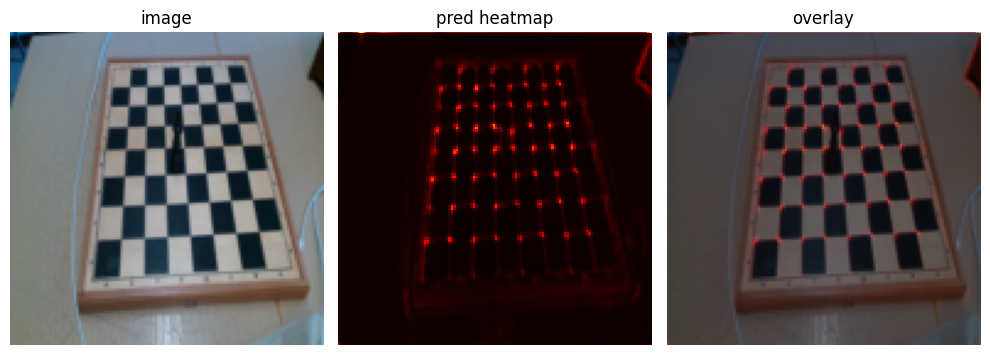

In [13]:
# visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("pred heatmap")
plt.imshow(pred, cmap="hot", interpolation="nearest")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("overlay")
plt.imshow(img)
plt.imshow(pred, cmap="hot", alpha=0.5, interpolation="nearest")
plt.axis("off")

plt.tight_layout()
plt.show()